In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile as zp
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torchvision

import torch.utils.data as data
import torch.nn.functional as F
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tqdm.notebook import trange,tqdm_notebook   #tqdm is a library that is used for creating Python Progress Bars
from tqdm import tqdm
import time
import random
import numpy as np

In [6]:
from torchvision.datasets import ImageFolder

# Calculating The pixel stats of SVHN dataset

In [8]:
batch_size_var = 64

train_dataset = torchvision.datasets.SVHN(root='./dataset_path', split='train', download=True,transform=transforms.Compose([transforms.ToTensor()]))  
# No other transformations so as to calculate pixel mean and SD
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_var, shuffle=True)

100%|██████████| 182040794/182040794 [00:13<00:00, 13956161.91it/s]


In [9]:
pixel_data = next(iter(train_loader))

pixels_mean = np.mean(pixel_data[0].numpy(), axis=(0, 2, 3))
pixels_std = np.std(pixel_data[0].numpy(), axis=(0, 2, 3))

print(pixels_mean)
print(pixels_std)

[0.41865906 0.42341977 0.45811155]
[0.19436772 0.19690497 0.19375879]


# we can apply tranforms with resize(AlexNet input 224x224) and Normalize with found mean and standard deviation!

In [10]:
#using the calculated mean and standard deviation

transform_var = transforms.Compose([ transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),
                    transforms.Normalize(mean=[0.46501136,0.46894032,0.49975333],std=[0.19131695,0.19763029,0.19317426]),]) # This mean and sd are taken from above calculation

# Downloading the dataset
## Loading the data into Dataloaders and applying Transforms

In [11]:
# Defining the batch size for data loaders
batch_size_var = 64

# Download and load the training dataset
train_dataset = torchvision.datasets.SVHN(root='./dataset_path', split='train', download=True, transform=transform_var)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_var, shuffle=True)

# Download and load the test dataset
test_dataset = torchvision.datasets.SVHN(root='./dataset_path', split='test', download=True, transform=transform_var)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_var, shuffle=False)


Using downloaded and verified file: ./dataset_path/train_32x32.mat


100%|██████████| 64275384/64275384 [00:06<00:00, 9333771.01it/s] 


In [12]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

73257
26032
1145
407


In [16]:
from torch.utils.data import Subset

In [17]:
# Download and load the test set
validation_dataset_full = torchvision.datasets.SVHN(root='./dataset_path', split='extra', download=True, transform=transform_var)


Using downloaded and verified file: ./dataset_path/extra_32x32.mat


In [18]:

validation_dataset = Subset(validation_dataset_full,range(int(0.03*len(validation_dataset_full))))  # 3% of the dataset has 15000+ images which might be enough for validation!

In [19]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size_var, shuffle=True)

In [20]:
print(len(validation_dataset_full))
print(len(validation_dataset))
print(len(validation_loader))

531131
15933
249


In [21]:
print("*"*50)
print(f"Length of Training data : {len(train_dataset)}")
print(f"Length of Testing data : {len(test_dataset)}")
print(f"Length of validation data : {len(validation_dataset)}")
print(f"Length of Training loader : {len(train_loader)}")
print(f"Length of Testing loader : {len(test_loader)}")
print(f"Length of validation loader : {len(validation_loader)}")
print("*"*50)

**************************************************
Length of Training data : 73257
Length of Testing data : 26032
Length of validation data : 15933
Length of Training loader : 1145
Length of Testing loader : 407
Length of validation loader : 249
**************************************************


# Insights and stats from the dataset 

In [ ]:
np.unique(train_dataset.labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,
         4659]))

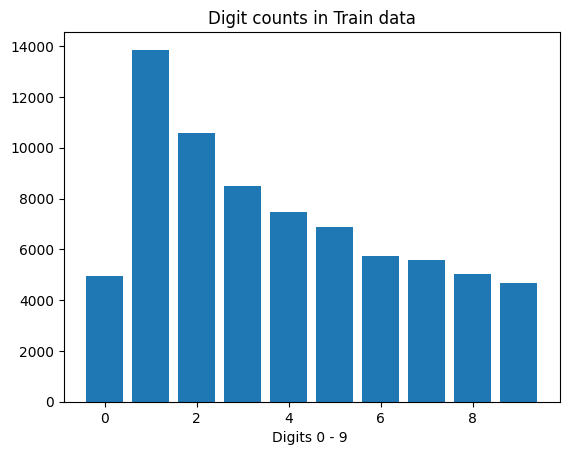

In [ ]:
plt.bar(range(10),[ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,4659])
plt.title("Digit counts in Train data")
plt.xlabel("Digits 0 - 9 ")
plt.show()

# Plotting 3X3 subplot and picking random images from the dataset

In [ ]:
def plot_random_images(iterator,indices):
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.title(iterator[indices[0]][1])
    plt.imshow(np.transpose(iterator[indices[0]][0],axes=(1,2,0))) 
    plt.subplot(332)
    plt.title(iterator[indices[1]][1])
    plt.imshow(np.transpose(iterator[indices[1]][0],axes=(1,2,0))) 
    plt.subplot(333)
    plt.title(iterator[indices[2]][1])
    plt.imshow(np.transpose(iterator[indices[2]][0],axes=(1,2,0)))
    plt.subplot(334)
    plt.title(iterator[indices[3]][1])
    plt.imshow(np.transpose(iterator[indices[3]][0],axes=(1,2,0)))
    plt.subplot(335)
    plt.title(iterator[indices[4]][1])
    plt.imshow(np.transpose(iterator[indices[4]][0],axes=(1,2,0)))
    plt.subplot(336)
    plt.title(iterator[indices[5]][1])
    plt.imshow(np.transpose(iterator[indices[5]][0],axes=(1,2,0)))
    plt.subplot(337)
    plt.title(iterator[indices[6]][1])
    plt.imshow(np.transpose(iterator[indices[6]][0],axes=(1,2,0)))
    plt.subplot(338)
    plt.title(iterator[indices[7]][1])
    plt.imshow(np.transpose(iterator[indices[7]][0],axes=(1,2,0)))
    plt.subplot(339)
    plt.title(iterator[indices[8]][1])
    plt.imshow(np.transpose(iterator[indices[8]][0],axes=(1,2,0)))
    plt.show()

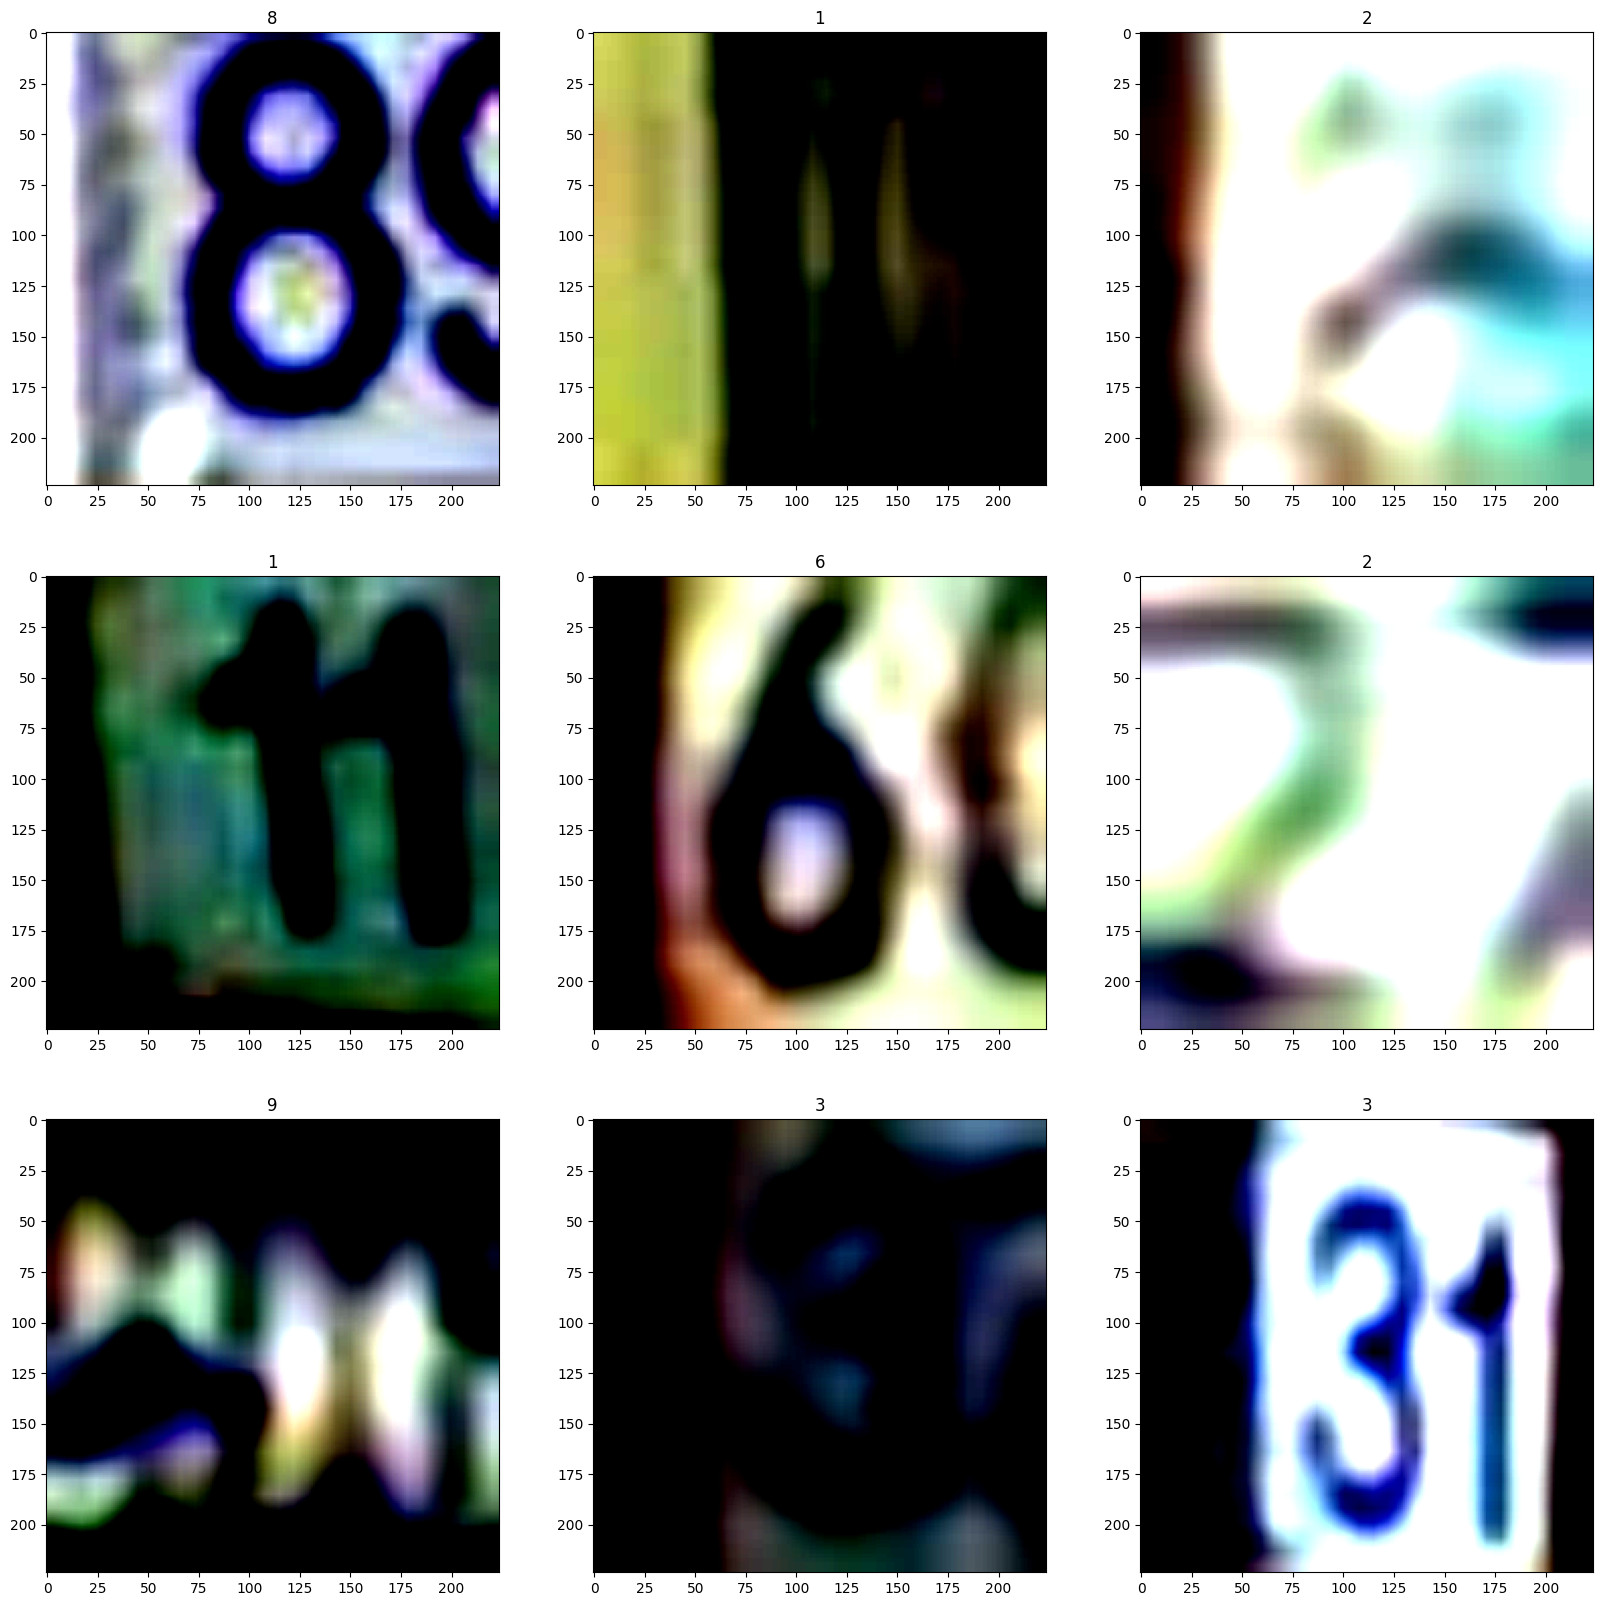

In [ ]:
plot_random_images(iterator=train_dataset,indices=random.sample(range(len(train_dataset)),9))

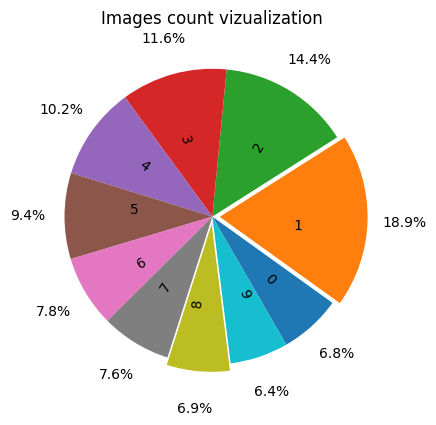

In [ ]:
lables = list(range(10))

figure, axis = plt.subplots()
axis.pie([ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,4659],labels=lables,autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=0.5,rotatelabels=20,explode=(0,0.05,0,0,0,0,0,0,0.05,0),startangle=300)
plt.title("Images count vizualization")
plt.show()

# Data Augmentation on Train Dataset

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(224), # input for AlexNet model
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # horizontally flips the image but random
    transforms.RandomVerticalFlip(), # vertically flips the image but random
    transforms.RandomRotation(degrees=10), # rotates image randomly by 10 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.5),  # applying something like a filter
    transforms.ToTensor(), #image to pixel values
    transforms.Normalize(mean=[0.46501136,0.46894032,0.49975333],std=[0.19131695,0.19763029,0.19317426])  # calculated mean and standard deviation
])

In [ ]:
# Download and load the training dataset
train_dataset_aug = torchvision.datasets.SVHN(root='./dataset_path', split='train', download=True, transform=train_transforms)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_var, shuffle=True)

print(f"Train dataset length : {len(train_dataset)}")
print(f"Augmented Train dataset length : {len(train_dataset_aug)}")

Using downloaded and verified file: ./dataset_path/train_32x32.mat
Train dataset length : 73257
Augmented Train dataset length : 73257


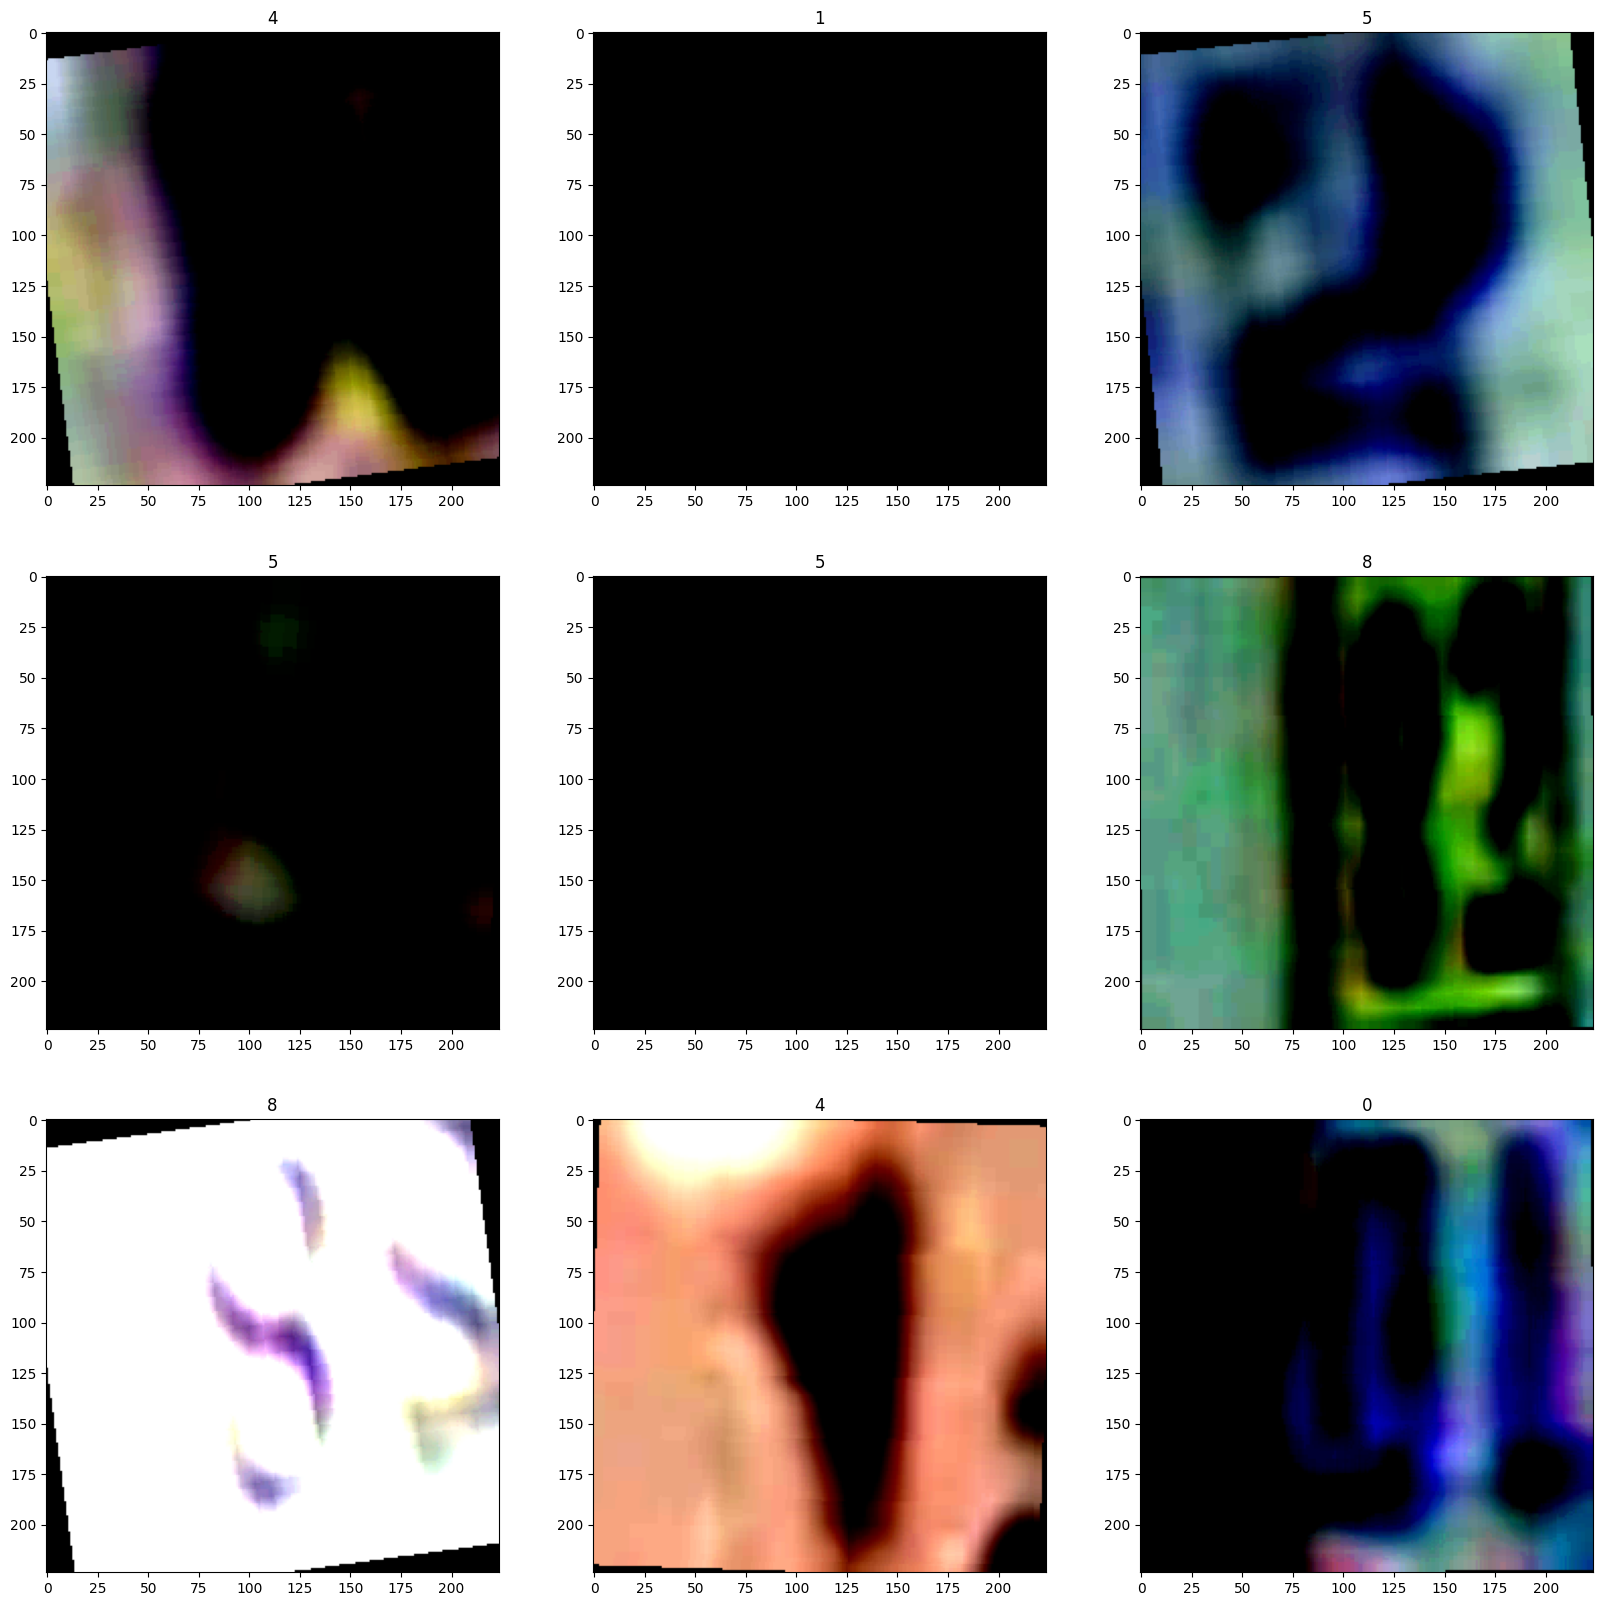

In [ ]:
plot_random_images(iterator=train_dataset_aug,indices=random.sample(range(len(train_dataset_aug)),9))

In [ ]:
print("Before applying Data Augmentation :")
print("*"*50)
print(f"Length of Training data : {len(train_dataset)}")
print(f"Length of Testing data : {len(test_dataset)}")
print(f"Length of validation data : {len(validation_dataset)}")
print(f"Length of Training loader : {len(train_loader)}")
print(f"Length of Testing loader : {len(test_loader)}")
print(f"Length of validation loader : {len(validation_loader)}")
print("*"*50)

Before applying Data Augmentation :
**************************************************
Length of Training data : 73257
Length of Testing data : 26032
Length of validation data : 15933
Length of Training loader : 1145
Length of Testing loader : 407
Length of validation loader : 249
**************************************************


# Train dataset is concatenated with Augmented train Dataset and used for moel training

In [ ]:
train_dataset_conc = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
print(len(train_dataset_conc))  # Doubled the size of Train datset as given in Assignment pdf


146514


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset_conc, batch_size=batch_size_var, shuffle=True)


In [ ]:
print("After Data Augmentation")
print("*"*50)
print(f"Length of Training data : {len(train_dataset_conc)}")
print(f"Length of Testing data : {len(test_dataset)}")
print(f"Length of validation data : {len(validation_dataset)}")
print(f"Length of Training loader : {len(train_loader)}")
print(f"Length of Testing loader : {len(test_loader)}")
print(f"Length of validation loader : {len(validation_loader)}")
print("*"*50)

After Data Augmentation
**************************************************
Length of Training data : 146514
Length of Testing data : 26032
Length of validation data : 15933
Length of Training loader : 2290
Length of Testing loader : 407
Length of validation loader : 249
**************************************************


# Random seed to reproduce the same conditions for working

In [22]:

seed_var = 69
random.seed(seed_var)
np.random.seed(seed_var)
torch.manual_seed(seed_var)
torch.cuda.manual_seed(seed_var)
torch.backends.cudnn.deterministic = True

# AlexNet model for SVHN Dataset

In [23]:
class AlexNetSVHN(nn.Module):
    def __init__(self, output_class=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.classifier(x)
        return x

In [24]:
# Funtion to count the trainable parameters in a model

def params_count(model):
    count = 0
    for parms in model.parameters():
        if parms.requires_grad:
            count+=parms.numel()
    
    print(f"The given model has {count} parameters to train")
    return count

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_alex = AlexNetSVHN(output_class=3).to(device)
print(device)

cuda


In [27]:
# Funtion to count the trainable parameters in a model

def params_count(model):
    count = 0
    for parms in model.parameters():
        if parms.requires_grad:
            count+=parms.numel()
    
    print(f"The given model has {count} parameters to train")
    return count

In [28]:
#parameter count 
params_count(model_alex)

The given model has 57176618 parameters to train


57176618

In [29]:
# function to calculate accuracy

def model_accuracy(y_true,y_pred):
    y_hat = y_pred.argmax(1,keepdim=True)
#     print("y_pred",y_pred)
    
    count = y_hat.eq(y_true.view_as(y_hat)).sum()
#     print("count",count)
    acc = count.float()/y_true.shape[0]
    return acc

In [30]:
# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex = model_alex.to(device)

In [31]:
# function for Training the model

def trainModel(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for x,y in iterator:
        x = x.to(device)   # images
        y = y.to(device)   # class - labels
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = criterion(y_pred,y)
        acc = model_accuracy(y_true=y,y_pred=y_pred)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    loss_var = epoch_loss/len(iterator)
    acc_var = epoch_acc/len(iterator)
    return epoch_loss/len(iterator) , epoch_acc/len(iterator)

In [32]:
# function for Testing the model

def evaluateModel(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad(): 
        for x,y in iterator:
            x = x.to(device)
            y = y.to(device)
#             optimizer.zero_grad()

            y_pred = model(x)

            loss = criterion(y_pred,y)
            acc = model_accuracy(y_true=y,y_pred=y_pred)

#             loss.backward()
#             optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator) , epoch_acc/len(iterator)

In [33]:
# function to calculate training and testing times

def time_stamps(st,et,name_tag = ""):  # start time:st ; end time :et
    run_time = -(st - et)
    run_time_mins = int(run_time/60)
    run_time_sec = int(run_time - run_time_mins*60)
    print()
    print(f"Elapsed time for {name_tag} is {run_time_mins} mins and {run_time_sec} seconds \n")
    return run_time
    

In [ ]:
num_epochs = 10
loss_best = float("inf")   # infinity
run_time_train_lst = []
run_time_test_lst = []
loss_train_list, loss_valid_list, loss_test_list = [],[],[]
acc_train_list, acc_valid_list, acc_test_list = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list.append(train_loss)
    loss_valid_list.append(validation_loss)
    acc_train_list.append(train_acc)
    acc_valid_list.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex.state_dict(),"model_best_state.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst.append(run_time)
    
    
    # testing using saved model state
#     model_alex.load_state_dict(torch.load("model_best_state.pt"))  # we will use this state to run after running all epochs
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list.append(test_loss)
    acc_test_list.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst = run_time_train_lst + run_time_test_lst
print(f"Total run time for all epochs is : {sum(run_time_lst)} | specific : {int(sum(run_time_lst)/60)} minutes and {sum(run_time_lst) - int(sum(run_time_lst)/60)*60} seconds ")


Elapsed time for Training and validation is 14 mins and 5 seconds 


Elapsed time for Testing is 2 mins and 0 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.19 | Train loss : 2.24
Validation accuracy : 0.18 | validation loss : 2.25
Test accuracy : 0.20 | Test loss : 2.22
************************************************************


Elapsed time for Training and validation is 14 mins and 10 seconds 


Elapsed time for Testing is 2 mins and 0 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.34 | Train loss : 1.85
Validation accuracy : 0.83 | validation loss : 0.55
Test accuracy : 0.76 | Test loss : 0.80
************************************************************


Elapsed time for Training and validation is 14 mins and 8 seconds 


Elapsed time for Testing is 2 m